# Kalman filter example

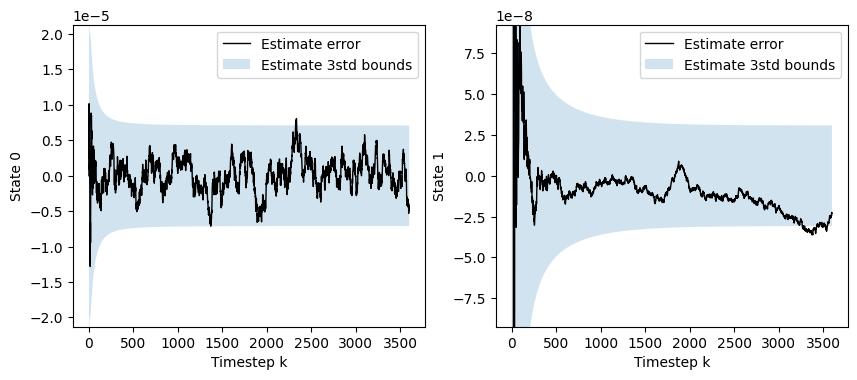

In [31]:
%matplotlib inline

import pysia as sia
import numpy as np
import matplotlib.pyplot as plt

# Define linear system from Crassidis and Junkins 2012, pp. 165, example 3.3.
# This is a flight attitude rate and bias error estimation system.  The state
# x = [attitude, rate bias error].  The input u = [measured attitude rate].
# The output is y = [measured attitude].
dt = 1
sn = 17E-6
su = np.sqrt(10)*1E-10
sv = np.sqrt(10)*1E-7
q00 = sv**2 * dt + su**2 * dt**3 / 3
q01 = - su**2 * dt**2 / 2
q11 = su**2 * dt
system = sia.LinearGaussian(
    A=np.array([[1, -dt], [0, 1]]),
    B=np.array([[dt], [0]]),
    C=np.array([[1, 0], [0, 1]]),
    H=np.array([[1, 0]]),
    Q=np.array([[q00, q01], [q01, q11]]),
    R=np.array([[sn**2]]))

# Initialize the state estimate and the kalman filter
estimate = sia.Gaussian(mean=np.array([0, 0]), covariance=np.diag([1E-4, 1E-12]))
kf = sia.KalmanFilter(system, state=estimate)

# Allocate a history trace for conveniently storing the evaluation results
n_steps = 3600
# trace = sia.Trace(buffer=n_steps)
# kf.setTrace(trace)

# Evaluate the Kalman filter for n_steps
t = np.arange(0, n_steps, 1)
y = np.zeros((n_steps, 1))
x = np.zeros((n_steps, 2))
x[0, :] = np.array([0, 4.8481e-7])
u = 0.0011 * np.ones((n_steps, 1))
xe_mu = np.zeros((n_steps, 2))
xe_var = np.zeros((n_steps, 2))
for k in range(1, n_steps):
    x[k, :] = system.dynamics(x[k-1, :], u[k, :]).sample()
    y[k, :] = system.measurement(x[k, :]).sample()
    estimate = kf.estimate(y[k, :], u[k, :])
    xe_mu[k, :] = estimate.mean()
    xe_var[k, :] = estimate.covariance().diagonal()

# Extract mean and covariance from buffer
fig, ax = plt.subplots(1, 2, sharex=True, figsize=(10, 4), dpi=100)
for i in range(2):
    plt.sca(ax[i])
    ax[i].fill_between(t, 
                       -3 * np.sqrt(xe_var[:, i]),
                       +3 * np.sqrt(xe_var[:, i]),
                       alpha=0.2, label="Estimate 3std bounds")
    ax[i].plot(t, x[:, i] - xe_mu[:, i], 'k', lw=1, label="Estimate error")
    ax[i].legend()
    plt.ylim(np.sqrt(xe_var[-1, i]) * np.array([-9, 9]))
    plt.ylabel("State " + str(i))
    plt.xlabel('Timestep k')
plt.show()

# Extended Kalman filter